# Data exploration of experimental events
* https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array
## Data import

In [1]:
# Imports
import matplotlib.pyplot as plt
from master_scripts.data_functions import get_git_root, import_real_data
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%load_ext autoreload
%autoreload 2


In [2]:
# CeBr2Mil_Mix.txt -> 2 million mixed samples of simulated events
REPO_ROOT = get_git_root()
DATA_PATH = REPO_ROOT + "/data/real/anodedata_500k.txt"
DATA_FILENAME = "anodedata_500k.txt"

events, images = import_real_data(DATA_PATH) # images not normalized

# Basic statistical properties
Means, standard deviations etc.

## Images
num_observations, (min, max), mean, variance, skewness, kurtosis

In [6]:
decays = [e['image_idx'] for e in events.values() if e['event_descriptor'] == 2]

In [9]:
print(len(decays))

260147


In [7]:
stats_images = stats.describe(images[decays])

In [8]:
# Print maximum and minimum pixel values seen in image data
print("{:15s}|{:^15s}|{:^15s}|{:^15s}|{:^15s}".format(
    "Image set",
    "pixel min",
    "pixel max",
    "pixel mean",
    "pixel STD (mean)"))
print("{:15s}|{:^15.2f}|{:^15.2f}|{:^15.2f}|{:^15.2f}".format(
    "All images", 
    np.amin(stats_images.minmax[0]),
    np.amax(stats_images.minmax[1]),
    np.mean(stats_images.mean),
    np.mean(np.sqrt(stats_images.variance))))

Image set      |   pixel min   |   pixel max   |  pixel mean   |pixel STD (mean)
All images     |     0.00      |    8530.83    |    226.38     |    337.86     


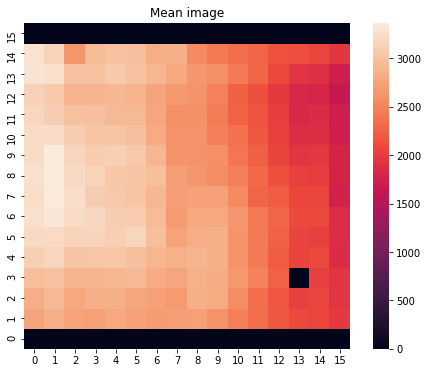

In [5]:
# Plot the mean image
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(stats_images[2].reshape((16,16)), ax=ax, square=True)
ax.set_title("Mean image")
ax.invert_yaxis()

## Highest intensity pixel heatmap
Extract the positions of highest intensity pixels across the dataset and plot the
resulting heatmap

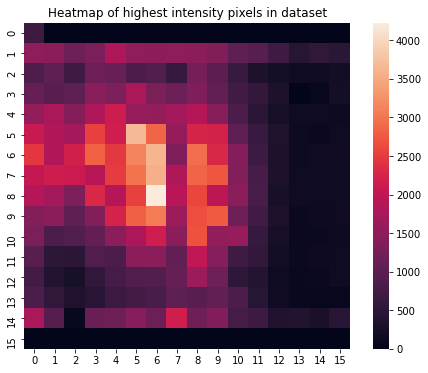

In [12]:
# Reshape input array to a 2D array with rows being kept as with original array.
# Then, get idnices of max values along the columns.
pix_hmap = np.zeros(images[0].shape)
max_idx = images.reshape(images.shape[0],-1).argmax(1)
# Get unravel indices corresponding to original shape of A
maxpos_vect = np.column_stack(np.unravel_index(max_idx, images[0,:,:].shape))
np.add.at(
    pix_hmap, 
    (
        maxpos_vect[decays, 0],
        maxpos_vect[decays, 1],
        maxpos_vect[decays, 2]
    ),
    1
)
#pix_hmap[maxpos_vect[:, 0], maxpos_vect[:, 1], maxpos_vect[:, 2]] += 1
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Heatmap of highest intensity pixels in dataset')
sns.heatmap(pix_hmap.reshape((16,16)), ax=ax, square=True)


## Where do "dead" pixels occur
Extract the positions of "dead" pixels across the dataset and plot the
resulting heatmap, annotated with ratio of images where the pixel is zero

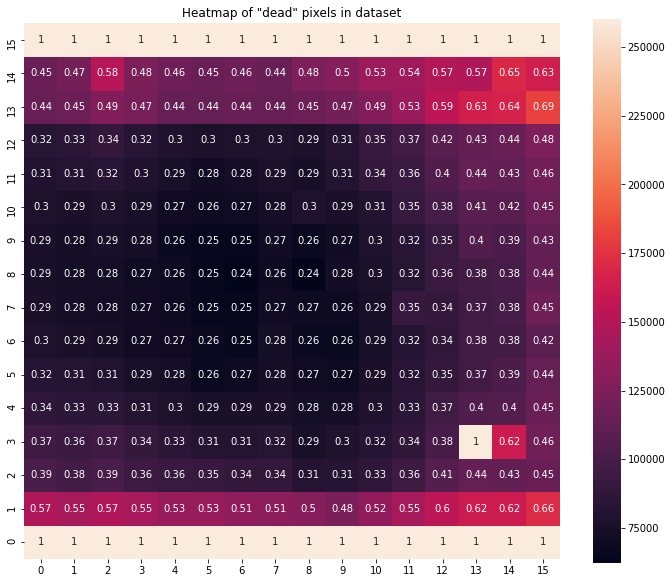

In [13]:
zeros_hmap = np.zeros(images[decays].shape)
np.add.at(zeros_hmap, np.where(images[decays] == 0), 1)
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title('Heatmap of "dead" pixels in dataset')
zeros_hmap = zeros_hmap.sum(axis=0)
ratios = (zeros_hmap/images[decays].shape[0]).reshape(16, 16)
sns.heatmap(zeros_hmap.reshape(16, 16), square=True, ax=ax, annot=ratios)
ax.invert_yaxis()